In [177]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter

In [178]:
class Vehicle:
    _id_counter = 0
    """Define vehicle attributes and rules to be implemented"""
    def __init__(self, x_position, speed, max_speed, length, width, road_designation, vehicle_type, current_row, lane_changing_prob):
        self.vehicle_id = Vehicle._id_counter  # Assign a unique ID to each vehicle
        Vehicle._id_counter += 1  #Increment the counter for the next vehicle
        self.x_position = x_position #position along the length of the road (x position)
        self.speed = speed #number of cells the vehicle will move per timestep
        self.max_speed = max_speed #maximum speed
        self.braking_prob = 0.01 #probability of random slowdown
        self.length = length #length of the vehicle is the number of cells the vehicle occupies along the length of the road
        self.width = width #width of the vehicle is the number of cells the vehicle occupies along the width of the road
        self.road_designation = road_designation #whether inside or outside
        self.vehicle_type = vehicle_type #type of vehicle is determined by the size and behavior
        self.current_row = current_row #also known as the y position of the right side of the vehicle
        self.lane_changing_prob = lane_changing_prob #probability that a vehicle will transfer lane
        self.lane_change_direction = None
        print(f"{self.vehicle_type} {self.vehicle_id} attributes")
        
    def accelerate(self):
        """Increases vehicle's speed by 1 cell, up to the maximum speed"""
        if self.speed < self.max_speed:
            self.speed += 1

    def gap_distance(self, vehicle_row_to_be_checked): 
        """Debugging this - make gap distance consider toroidal boundary cond. recently introduced"""
        """vehicle row to be checked: Input is row 0, you check for lane 1(row 0 and 1). Input is row 1, you check for lane at the middle (row 1 and 2). Input is row 2, you check for lane 2(rows 2 and 3)."""
        rear_bumper_position = self.x_position
        print(f"{self.vehicle_type} {self.vehicle_id}'s rear bumper is at {rear_bumper_position}")
        front_bumper_position = rear_bumper_position + self.length - 1
        print(f"{self.vehicle_type} {self.vehicle_id}'s front bumper is at {front_bumper_position}")
        max_distance = self.speed #maximum distance checked is equivalent to speed
        print(f"{self.vehicle_type} {self.vehicle_id}'s maximum distance is  {max_distance}")
        road_length = self.road_designation.road_length
        #print(f"{self.vehicle_type} {self.vehicle_id}'s road has length of {road_length}")
        
        gap_distance = max_distance
        #print(f"{self.vehicle_type} {self.vehicle_id}: default gap distance is {gap_distance}")
        
        for distance in range(1, max_distance + 1):
            start_of_space_to_be_checked = (rear_bumper_position + self.length + distance - 1)  % road_length
            #print(f"{self.vehicle_type} {self.vehicle_id}: next rear bumper position is {start_of_space_to_be_checked}")
            end_of_space_to_be_checked = (front_bumper_position + max_distance)  % road_length #We have to include the front bumper position, to avoid vehicle overlaps
            #print(f"{self.vehicle_type} {self.vehicle_id}: next front bumper position is {end_of_space_to_be_checked}")
            
            # Check if there's an occupied space within the distance
            if start_of_space_to_be_checked < end_of_space_to_be_checked:
                #print(f"Checking occupancy from {start_of_space_to_be_checked} to {end_of_space_to_be_checked} in row {vehicle_row_to_be_checked}")
                #print(self.road_designation.road_occupancy[start_of_space_to_be_checked, vehicle_row_to_be_checked:vehicle_row_to_be_checked + self.width])
                if np.sum(self.road_designation.road_occupancy[start_of_space_to_be_checked, vehicle_row_to_be_checked:vehicle_row_to_be_checked + self.width]) != 0:
                    gap_distance = distance - 1
                    print(np.sum(self.road_designation.road_occupancy[start_of_space_to_be_checked, vehicle_row_to_be_checked:vehicle_row_to_be_checked + self.width]))
                    break
            else:  # Wrap-around case
                #print(f"Checking occupancy wrap-around from {start_of_space_to_be_checked} to end and from start to {end_of_space_to_be_checked} in row {vehicle_row_to_be_checked}")
                #print(self.road_designation.road_occupancy[start_of_space_to_be_checked:, vehicle_row_to_be_checked:vehicle_row_to_be_checked + self.width])
                #print(self.road_designation.road_occupancy[:end_of_space_to_be_checked + 1, vehicle_row_to_be_checked:vehicle_row_to_be_checked + self.width])
                if np.sum(self.road_designation.road_occupancy[start_of_space_to_be_checked, vehicle_row_to_be_checked:vehicle_row_to_be_checked + self.width]) != 0: #or \
                   #np.sum(self.road_designation.road_occupancy[:end_of_space_to_be_checked + 1, vehicle_row_to_be_checked:vehicle_row_to_be_checked + self.width]) != 0:
                    gap_distance = distance - 1
                    print(np.sum(self.road_designation.road_occupancy[start_of_space_to_be_checked, vehicle_row_to_be_checked:vehicle_row_to_be_checked + self.width]))
                    break
        if gap_distance < 0: #For debugging
            print(f"Error, negative gap distance of {gap_distance}, at rear bumper position {current_x_position}") #Results to negative headway distance
        print(f"{self.vehicle_type} {self.vehicle_id} has a gap distance of {gap_distance}")
        return gap_distance # Return the  gap distance

    def lane_changing(self):
        """attempts to change lanes based on vehicle type and lane availability
        Here, we define a lane as a space of 2 cells wide. We assume a two-lane road(4 cells wide).
        We assume that each half lane is an array, imagine a vertical stack of arrays, indexing is 0 to 4 (bottom to top). Right side is the bottom."""
        #new_row = self.current_row #by default, vehicle stays on its lane
        print(f"Vehicle {self.vehicle_id} is located at row {self.current_row} with a speed of {self.speed}")
        gap_distance_of_own_lane = self.gap_distance(self.current_row) #obtains the gap distance of current lane
        print(f"{self.vehicle_type}{self.vehicle_id} has a gap distance of {gap_distance_of_own_lane} in its lane, vehicle row is {self.current_row}")
        gap_distance_of_adjacent_right_lane = self.gap_distance(self.current_row - 2) if self.current_row == 2 else gap_distance_of_own_lane #I can either set this equal to the current gap distance or to zero
        print(f" The adjacent right lane of {self.vehicle_type} {self.vehicle_id} has an available space of {gap_distance_of_adjacent_right_lane} cells.")
        gap_distance_of_adjacent_left_lane = self.gap_distance(self.current_row + 2) if self.current_row == 0 else gap_distance_of_own_lane #I can either set this equal to the current gap distance or to zero
        print(f" The adjacent left lane of {self.vehicle_type} {self.vehicle_id} has an available space of {gap_distance_of_adjacent_left_lane} cells.")

        if self.speed > gap_distance_of_own_lane and self.speed > 0: # we cannot allow tailgated (vehicles having v = 0) vehicles to change lanes
            if self.current_row == 0 and gap_distance_of_adjacent_left_lane > gap_distance_of_own_lane: #There are specific cases wherein changing to the right or left lane is possible/legal
                self.lane_change_direction = 'left'
                #print(self.road_designation.road_occupancy[self.x_position:self.x_position + self.length, self.current_row:self.current_row+2+ self.width])
                if np.sum(self.road_designation.road_occupancy[self.x_position:self.x_position + gap_distance_of_own_lane +self.length, self.current_row+2:self.current_row+2+ self.width]) == 0:
                    self.speed = gap_distance_of_own_lane - 1
                    if self.speed > 0:
                        if np.sum(self.road_designation.road_occupancy[self.x_position+self.length:self.x_position +self.speed+self.length, self.current_row:self.current_row+self.width]) == 0: #This might be redundant with self.speed = gap distance - 1
                            self.current_row += 1  # Begin straddling
                            self.move()
                            print(f"{self.vehicle_type} {self.vehicle_id} is now straddling on row {self.current_row}")
            elif self.current_row == 2 and gap_distance_of_adjacent_right_lane > gap_distance_of_own_lane: 
                self.lane_change_direction = 'right'
                #print(self.road_designation.road_occupancy[self.x_position:self.x_position + self.length, self.current_row:self.current_row-2+ self.width])
                if np.sum(self.road_designation.road_occupancy[self.x_position:self.x_position +gap_distance_of_own_lane+ self.length, self.current_row-2:self.current_row-2+ self.width]) == 0:
                    self.speed = gap_distance_of_own_lane - 1
                    if self.speed>0:
                        if np.sum(self.road_designation.road_occupancy[self.x_position+self.length:self.x_position +self.speed+self.length, self.current_row-self.width:self.current_row]) == 0:
                            self.current_row -= 1  # Begin straddling
                            self.move()
                            print(f"{self.vehicle_type} {self.vehicle_id} is now straddling on row {self.current_row}")
        else:
            pass
                    
        # Apply lane change (straddling)
        """print(self.road_designation.road_occupancy[self.x_position:self.x_position + self.length, new_row:new_row + self.width])
        if np.sum(self.road_designation.road_occupancy[self.x_position:self.x_position + self.length, new_row:new_row + self.width]) == 0:
            print(self.road_designation.road_occupancy[self.x_position:self.x_position + self.length, new_row:new_row + self.width])
            self.current_row = new_row
            print(f"Vehicle {self.vehicle_id} is now straddling on row {new_row}")"""        
        return
        
       # self.test = 1
        #For debugging:
        #if self.speed < gap_distance_of_own_lane:
            #print(vehicle.gap_distance, gap_distance_of_own_lane, vehicle.speed)
        #if gap_distance_of_own_lane < 0:
            #print(f"{self.vehicle_type} {vehicle.vehicle_id} invalid")

    def handle_straddling(self):
        """Complete the lane change if straddling"""
        if self.current_row == 1:
                if self.lane_change_direction == 'right':
                    if self.speed > 0:
                        if np.sum(self.road_designation.road_occupancy[self.x_position+self.length:self.x_position+self.length + self.speed, self.current_row]) == 0:
                            self.current_row = 0  # Complete change to the right lane
                            self.move()
                            #self.speed = gap_distance_of_own_lane - 1
                            print(f"Vehicle {self.vehicle_id}'s is in row {self.current_row}")
                            self.lane_change_direction = None
                            print(f"Vehicle {self.vehicle_id} completed right lane change")
                        else:
                            self.decelerate()
                    else:
                        if np.sum(self.road_designation.road_occupancy[self.x_position+self.length:self.x_position +self.length+ 2, self.current_row]) == 0:
                            self.accelerate()
                            self.current_row = 0
                            self.move()
                            #self.speed = gap_distance_of_own_lane - 1
                            print(f"Vehicle {self.vehicle_id}'s is in row {self.current_row}")
                            self.lane_change_direction = None
                            print(f"Vehicle {self.vehicle_id} completed right lane change")
                elif self.lane_change_direction == 'left':
                    if self.speed > 0:
                        if np.sum(self.road_designation.road_occupancy[self.x_position+self.length:self.x_position + self.length + self.speed, self.current_row+1]) == 0:
                            self.current_row = 2  # Complete change to the left lane
                            self.move()
                            #self.speed = gap_distance_of_own_lane - 1
                            print(f"Vehicle {self.vehicle_id}'s is in row {self.current_row}")
                            self.lane_change_direction = None
                            print(f"Vehicle {self.vehicle_id} completed left lane change")
                        else:
                            self.decelerate()
                    else:
                        if np.sum(self.road_designation.road_occupancy[self.x_position+self.length:self.x_position + self.length + 2, self.current_row+1]) == 0:
                            self.accelerate()
                            self.current_row = 2
                            self.move()
                            #self.speed = gap_distance_of_own_lane - 1
                            print(f"Vehicle {self.vehicle_id}'s is in row {self.current_row}")
                            self.lane_change_direction = None
                            print(f"Vehicle {self.vehicle_id} completed left lane change")
        # Check space before completing lane change
        '''if np.sum(self.road_designation.road_occupancy[self.x_position:self.x_position + self.length, self.current_row]) == 0:
            print(self.road_designation.road_occupancy[self.x_position:self.x_position + self.length, self.current_row])
            print(f"{self.vehicle_type} {self.vehicle_id} successfully moved to row {self.current_row}")'''

    def decelerate(self):
        """decreases vehicle's speed to match the gap distance, given the speed>gap distance"""
        gap_distance_of_own_lane = self.gap_distance(self.current_row)
        if self.speed > gap_distance_of_own_lane:
            self.speed = gap_distance_of_own_lane

    def braking(self):
        """Mimics random slowdown, randomly decreases vehicle's speed based on braking probability """
        if np.random.rand() < self.braking_prob and self.speed > 0:
            self.speed -= 1
            #print(f"{self.vehicle_type} {self.vehicle_id} is braking")


    def move(self):
        """implements movement"""
        new_position = (self.x_position + self.speed) % self.road_designation.road_length
        self.x_position = new_position

In [179]:
class Road:
    def __init__(self, road_length, road_width, speed_limit):
        self.road_length = road_length
        self.road_width = road_width
        self.speed_limit = speed_limit
        self.road_occupancy = np.zeros((road_length, road_width))

In [180]:
class IntraRoadSimulator:
    def __init__(self, road):
        """This method stores the input agents and initializes output data"""
        self.road = road  # Store the road instance
        self.vehicles = []  # List to store vehicle instances
        self.occupancy_history = []  # List to store the history of road occupancy states
        #self.throughput_counter = ThroughputCounter(position=99)

    def update_occupancy(self):
        """This method updates road occupancy based on vehicle position and length"""
        self.road.road_occupancy.fill(0)
        for vehicle in self.vehicles:
            x_start = vehicle.x_position
            x_end = (vehicle.x_position + vehicle.length) % self.road.road_length #from vehicle rear bumper(position|) to front, minus 1. takes account of toroidal boundaries
            y_start = vehicle.current_row
            y_end = min(vehicle.current_row + vehicle.width, self.road.road_width)
            if x_start < x_end:
                if vehicle.vehicle_type == "jeep":
                    self.road.road_occupancy[x_start:x_end, y_start:y_end] = 1
                else:
                    self.road.road_occupancy[x_start:x_end, y_start:y_end] = 2
            else:
                if vehicle.vehicle_type == "jeep":
                    self.road.road_occupancy[x_start:, y_start:y_end] = 1
                    self.road.road_occupancy[:x_end, y_start:y_end] = 1
                else:
                    self.road.road_occupancy[x_start:, y_start:y_end] = 2
                    self.road.road_occupancy[:x_end, y_start:y_end] = 2
        self.occupancy_history.append(self.road.road_occupancy.copy())

    def place_vehicle(self, vehicle_type, length, width, lane_changing_prob):
        row_options = [0, 2]
        for i, row in enumerate(row_options * (self.road.road_length // 2)):
            x_position = i % self.road.road_length  #Cycles through each position based on road length
            if self.road.road_occupancy[x_position:x_position + length, row:row + width].sum() == 0:
                new_vehicle = Vehicle(x_position, 0, self.road.speed_limit, length, width, self.road,
                                              vehicle_type, row, lane_changing_prob)
                self.vehicles.append(new_vehicle)
                self.road.road_occupancy[x_position:x_position + length, row:row + width] = 1 if vehicle_type == 'jeep' else 2
                return
        print(f"No space available for {vehicle_type}")

    def initialize_vehicles(self, density, truck_fraction, truck_lane_change_prob, jeep_lane_change_prob):
        A, B = 7 * 2, 3 * 2
        L, W = self.road.road_length, self.road.road_width
        N = int((density * L * W)*((truck_fraction/A) + ((1 - truck_fraction)/ B)))
        
        truck_count = int(N * truck_fraction)
        jeep_count = N - truck_count
        
        # Add trucks
        for _ in range(truck_count):
            self.place_vehicle('truck', 7, 2, truck_lane_change_prob)
        
        # Add jeeps
        for _ in range(jeep_count):
            self.place_vehicle('jeep', 3, 2, jeep_lane_change_prob)
        
        # Report actual density
        occupied_cells = sum(v.length * v.width for v in self.vehicles)
        actual_density = occupied_cells / (L * W)
        print(f"Actual density: {actual_density}")
    
    def simulation_step(self):
        np.random.shuffle(self.vehicles)
        for vehicle in self.vehicles:
            if vehicle.current_row == 1: # We  dont have to check for speed because vehicles cannot straddle if their v = 0
                vehicle.handle_straddling() 
                self.update_occupancy()
            elif np.random.rand() < vehicle.lane_changing_prob:
                print("calling lane changing method")
                # Change lane if possible
                vehicle.lane_changing()
                vehicle.accelerate()
                #print(f"ACCELERATE DEBUGGER: {vehicle.vehicle_type} {vehicle.vehicle_id} has accelerated at a speed of {vehicle.speed}")
                vehicle.decelerate() # Decelerate if necessar
                vehicle.braking()
                #print(f"BEFORE MOVE DEBUGGER: {vehicle.vehicle_type} {vehicle.vehicle_id} is at position {vehicle.x_position}")
                #self.throughput_counter.count_vehicle(vehicle)
               
                vehicle.move()  # Move the vehicle
                #print(f"AFTER MOVE DEBUGGER: {vehicle.vehicle_type} {vehicle.vehicle_id} is at position {vehicle.x_position}, with a speed of {vehicle.speed} at row {vehicle.current_row}")
                self.update_occupancy()  # Update the road occupancy grid
                #self.throughput_counter.count_vehicles_at_timestep(self.vehicles)
            else:
                vehicle.accelerate()
                vehicle.decelerate() 
                vehicle.braking()
                vehicle.move()
                self.update_occupancy() 
                
        
    def visualize(self, step_count):
        plt.figure(figsize=(20, 6))
        plt.imshow(self.road.road_occupancy.T, cmap='gray_r', origin='lower')
        plt.title(f'Step {step_count}')
        plt.xlabel('Road Length')
        plt.ylabel('Lane')
        plt.xticks(range(0, self.road.road_length + 1, 1))
        plt.yticks(range(0, self.road.road_width + 1, 1))
        plt.tight_layout()
        plt.show()

truck 0 attributes
truck 1 attributes
truck 2 attributes
truck 3 attributes
jeep 4 attributes
jeep 5 attributes
jeep 6 attributes
jeep 7 attributes
jeep 8 attributes
jeep 9 attributes
jeep 10 attributes
jeep 11 attributes
jeep 12 attributes
jeep 13 attributes
jeep 14 attributes
jeep 15 attributes
jeep 16 attributes
jeep 17 attributes
jeep 18 attributes
jeep 19 attributes
Actual density: 0.76


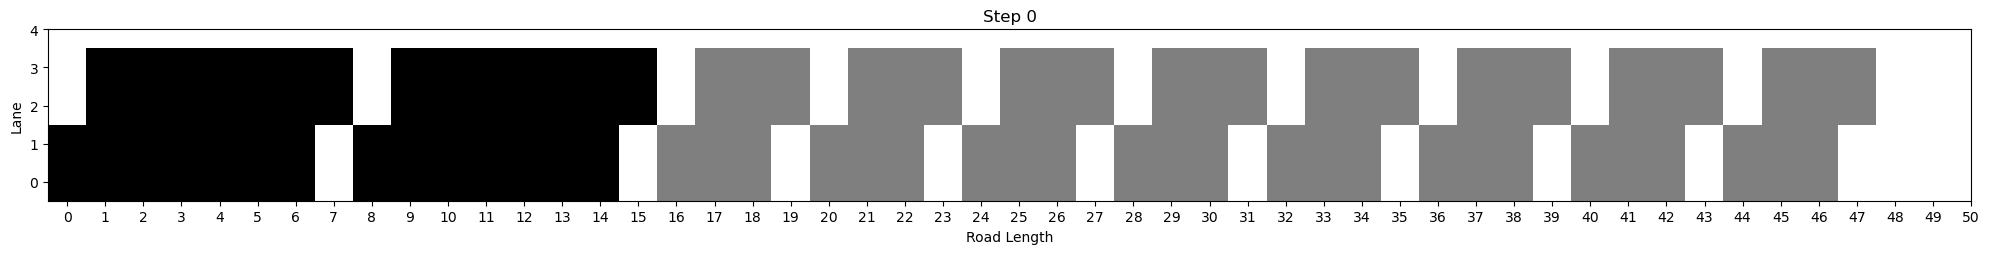

calling lane changing method
Vehicle 10 is located at row 0 with a speed of 0
jeep 10's rear bumper is at 28
jeep 10's front bumper is at 30
jeep 10's maximum distance is  0
jeep 10 has a gap distance of 0
jeep10 has a gap distance of 0 in its lane, vehicle row is 0
 The adjacent right lane of jeep 10 has an available space of 0 cells.
jeep 10's rear bumper is at 28
jeep 10's front bumper is at 30
jeep 10's maximum distance is  0
jeep 10 has a gap distance of 0
 The adjacent left lane of jeep 10 has an available space of 0 cells.
jeep 10's rear bumper is at 28
jeep 10's front bumper is at 30
jeep 10's maximum distance is  1
jeep 10 has a gap distance of 1
calling lane changing method
Vehicle 5 is located at row 2 with a speed of 0
jeep 5's rear bumper is at 17
jeep 5's front bumper is at 19
jeep 5's maximum distance is  0
jeep 5 has a gap distance of 0
jeep5 has a gap distance of 0 in its lane, vehicle row is 2
jeep 5's rear bumper is at 17
jeep 5's front bumper is at 19
jeep 5's maxim

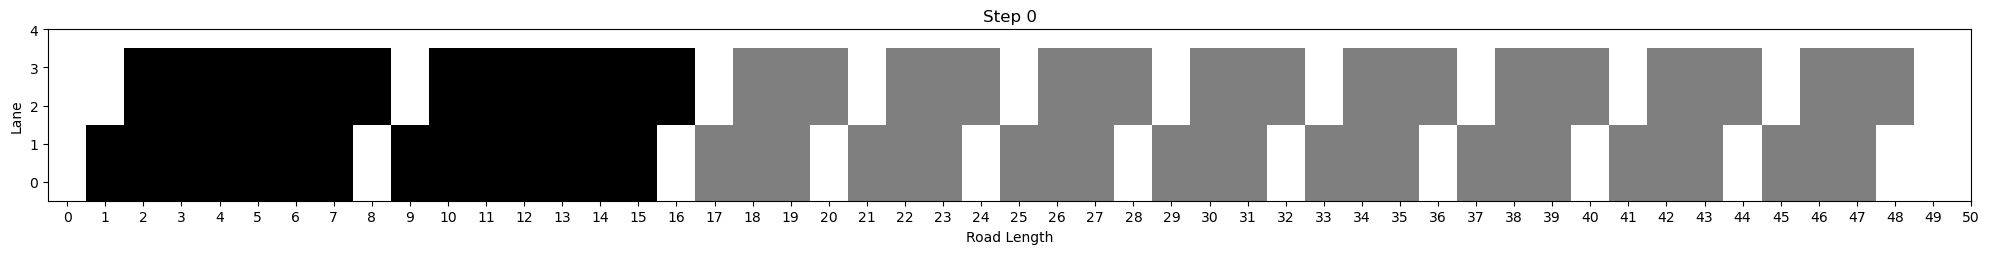

[[0. 0. 0. 0.]
 [2. 2. 0. 0.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [0. 0. 2. 2.]
 [2. 2. 0. 0.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [0. 0. 2. 2.]
 [1. 1. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 0. 0.]]
calling lane changing method
Vehicle 14 is located at row 0 with a speed of 1
jeep 14's rear bumper is at 37
jeep 14's front bumper is at 39
jeep 14's maximum distance is  1
jeep 14 has a gap distance of 1
jeep14 has a gap distance of 1 in its lane,

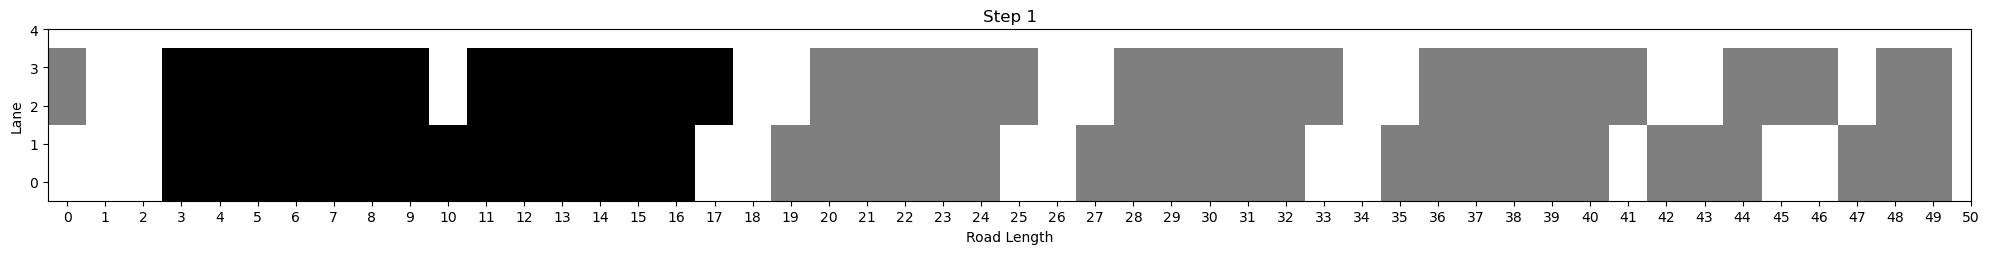

[[0. 0. 1. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 0. 0.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [0. 0. 2. 2.]
 [0. 0. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
calling lane changing method
Vehicle 17 is located at row 2 with a speed of 2
jeep 17's rear bumper is at 44
jeep 17's front bumper is at 46
jeep 17's maximum distance is  2
2.0
jeep 17 has a gap distance of 1
jeep17 has a gap distance of 1 in its l

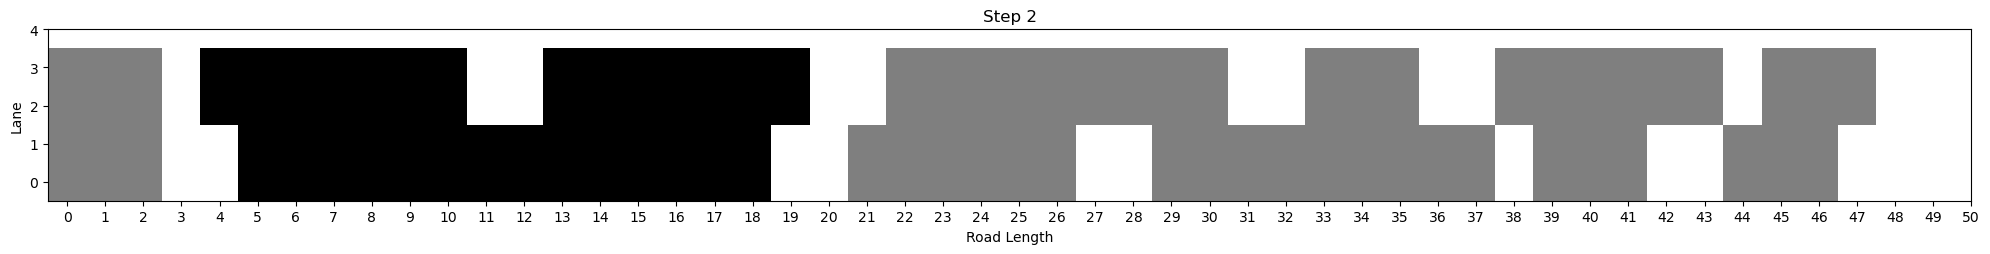

[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 0. 0.]
 [0. 0. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 0. 0.]
 [2. 2. 0. 0.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [0. 0. 2. 2.]
 [0. 0. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [0. 0. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
calling lane changing method
Vehicle 13 is located at row 2 with a speed of 2
jeep 13's rear bumper is at 38
jeep 13's front bumper is at 40
jeep 13's maximum distance is  2
2.0
jeep 13 has a gap distance of 0
jeep13 has a gap distance of 0 in its l

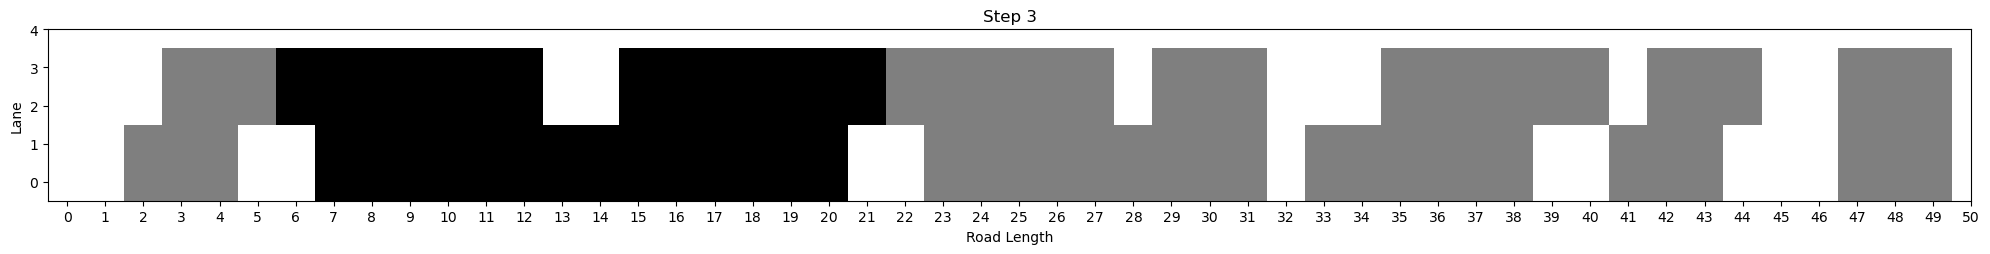

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 0. 0.]
 [2. 2. 0. 0.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [0. 0. 2. 2.]
 [0. 0. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
calling lane changing method
Vehicle 9 is located at row 2 with a speed of 1
jeep 9's rear bumper is at 29
jeep 9's front bumper is at 31
jeep 9's maximum distance is  1
jeep 9 has a gap distance of 1
jeep9 has a gap distance of 1 in its lane, vehic

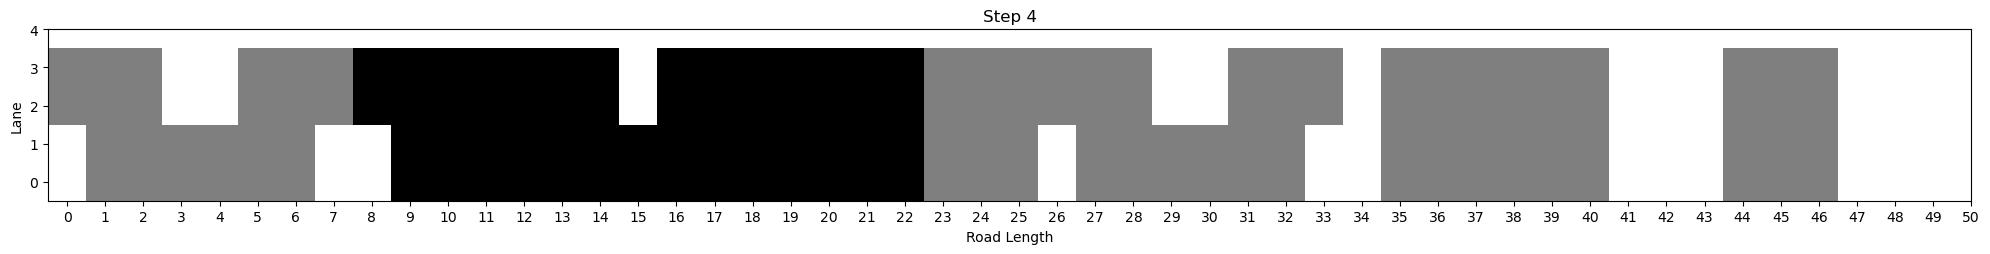

[[0. 0. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 0. 0.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
calling lane changing method
Vehicle 19 is located at row 2 with a speed of 2
jeep 19's rear bumper is at 5
jeep 19's front bumper is at 7
jeep 19's maximum distance is  2
4.0
jeep 19 has a gap distance of 0
jeep19 has a gap distance of 0 in its lan

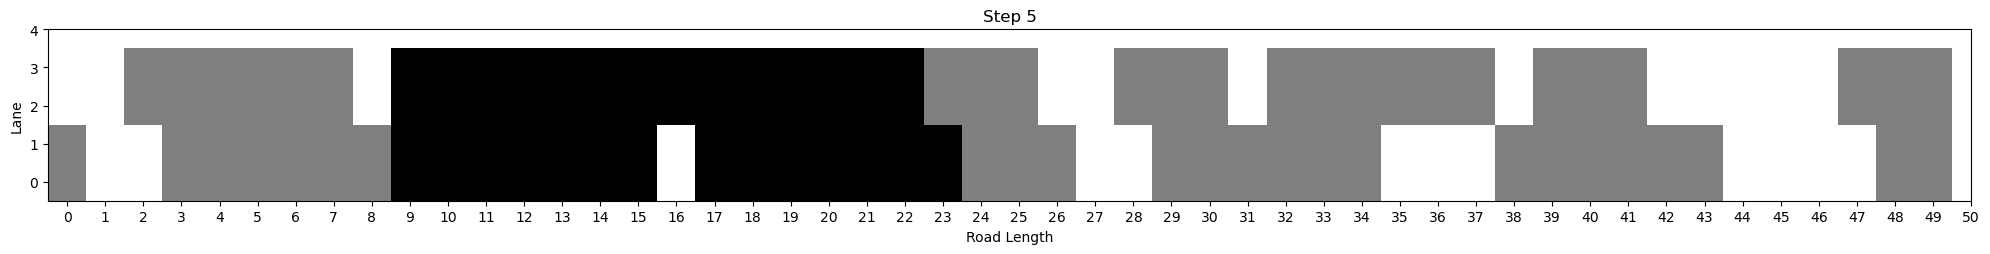

[[1. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 0. 0.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [0. 0. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
calling lane changing method
Vehicle 3 is located at row 2 with a speed of 0
truck 3's rear bumper is at 16
truck 3's front bumper is at 22
truck 3's maximum distance is  0
truck 3 has a gap distance of 0
truck3 has a gap distance of 0 in its lane, 

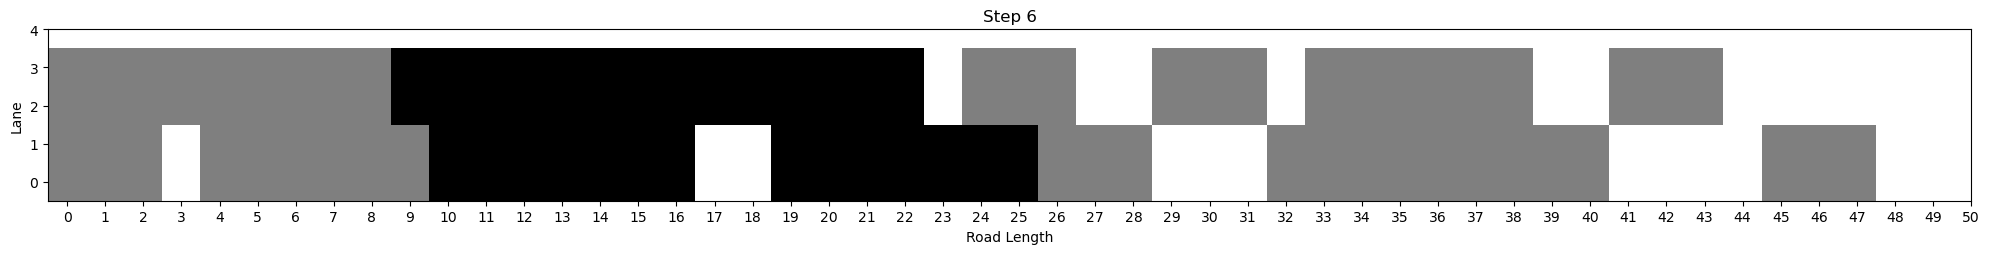

[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [0. 0. 2. 2.]
 [0. 0. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 0. 0.]
 [2. 2. 1. 1.]
 [2. 2. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [0. 0. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [0. 0. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
calling lane changing method
Vehicle 12 is located at row 0 with a speed of 4
jeep 12's rear bumper is at 45
jeep 12's front bumper is at 47
jeep 12's maximum distance is  4
2.0
jeep 12 has a gap distance of 2
jeep12 has a gap distance of 2 in its l

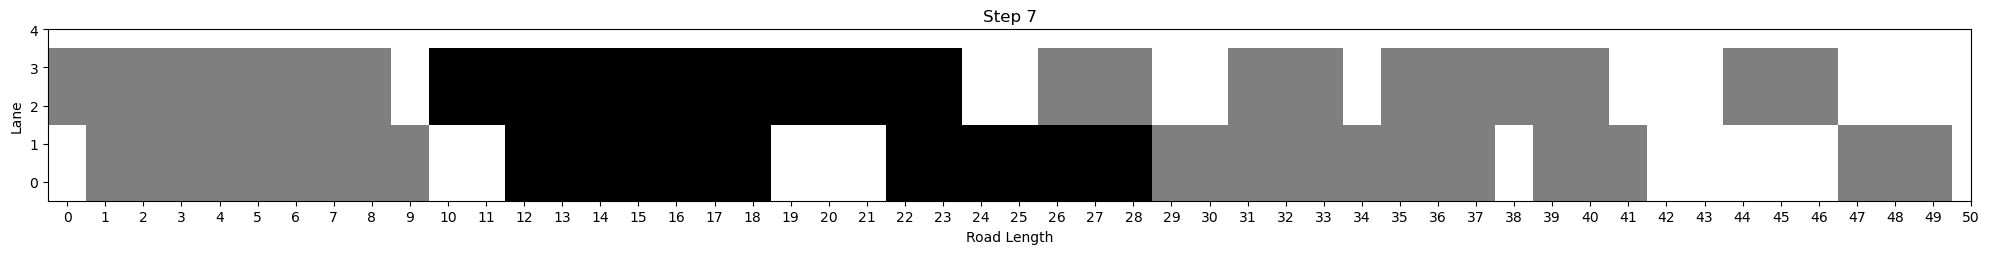

[[0. 0. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 0. 0.]
 [0. 0. 2. 2.]
 [0. 0. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [0. 0. 2. 2.]
 [0. 0. 2. 2.]
 [0. 0. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 0. 0.]
 [2. 2. 0. 0.]
 [2. 2. 1. 1.]
 [2. 2. 1. 1.]
 [2. 2. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]]
calling lane changing method
Vehicle 0 is located at row 0 with a speed of 2
truck 0's rear bumper is at 12
truck 0's front bumper is at 18
truck 0's maximum distance is  2
truck 0 has a gap distance of 2
truck0 has a gap distance of 2 in its lane, 

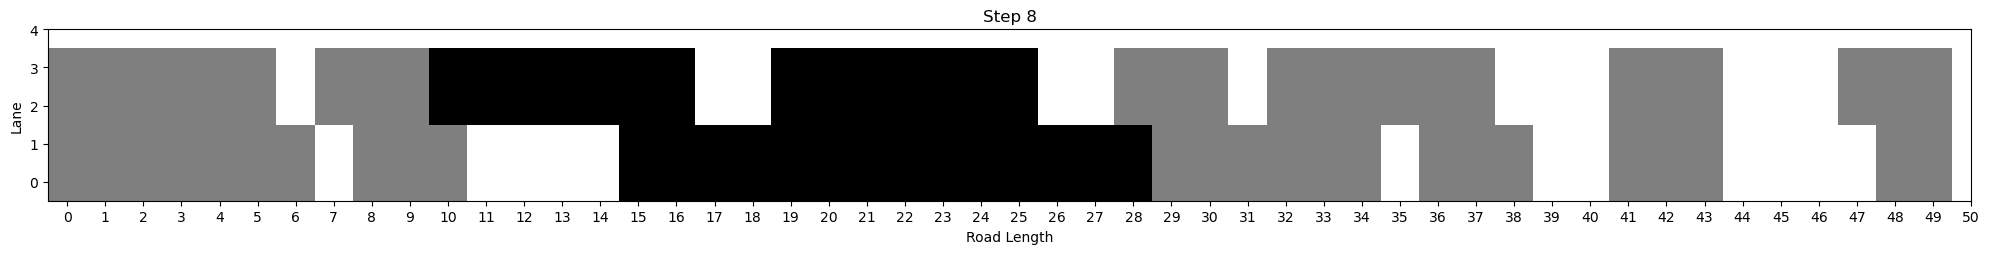

[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 0. 0.]
 [0. 0. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 2. 2.]
 [0. 0. 2. 2.]
 [0. 0. 2. 2.]
 [0. 0. 2. 2.]
 [0. 0. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 0. 0.]
 [2. 2. 0. 0.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 0. 0.]
 [2. 2. 0. 0.]
 [2. 2. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
calling lane changing method
Vehicle 8 is located at row 0 with a speed of 1
jeep 8's rear bumper is at 36
jeep 8's front bumper is at 38
jeep 8's maximum distance is  1
jeep 8 has a gap distance of 1
jeep8 has a gap distance of 1 in its lane, vehic

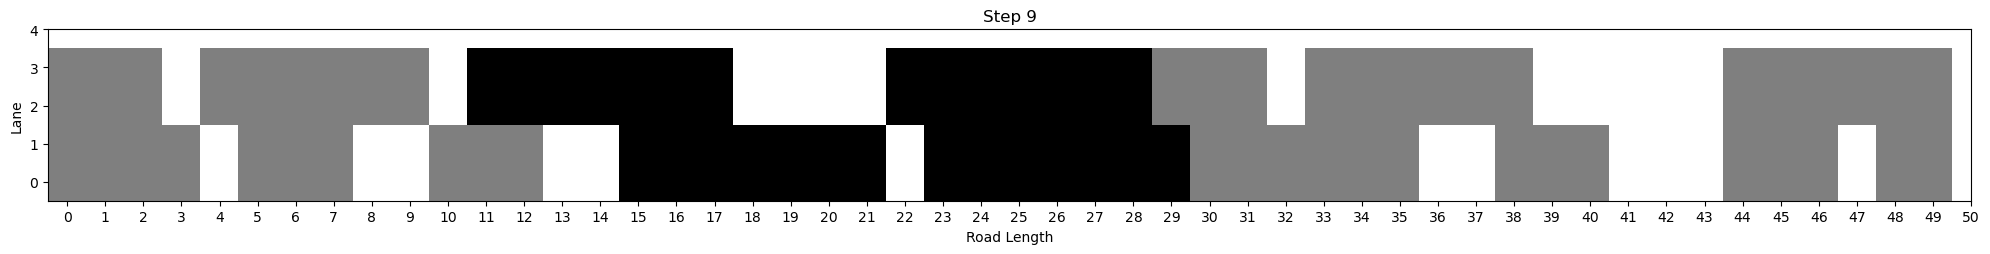

[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 0. 0.]
 [0. 0. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 2. 2.]
 [1. 1. 2. 2.]
 [0. 0. 2. 2.]
 [0. 0. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 0. 0.]
 [2. 2. 0. 0.]
 [2. 2. 0. 0.]
 [2. 2. 0. 0.]
 [0. 0. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
calling lane changing method
Vehicle 13 is located at row 2 with a speed of 0
jeep 13's rear bumper is at 47
jeep 13's front bumper is at 49
jeep 13's maximum distance is  0
jeep 13 has a gap distance of 0
jeep13 has a gap distance of 0 in its lane,

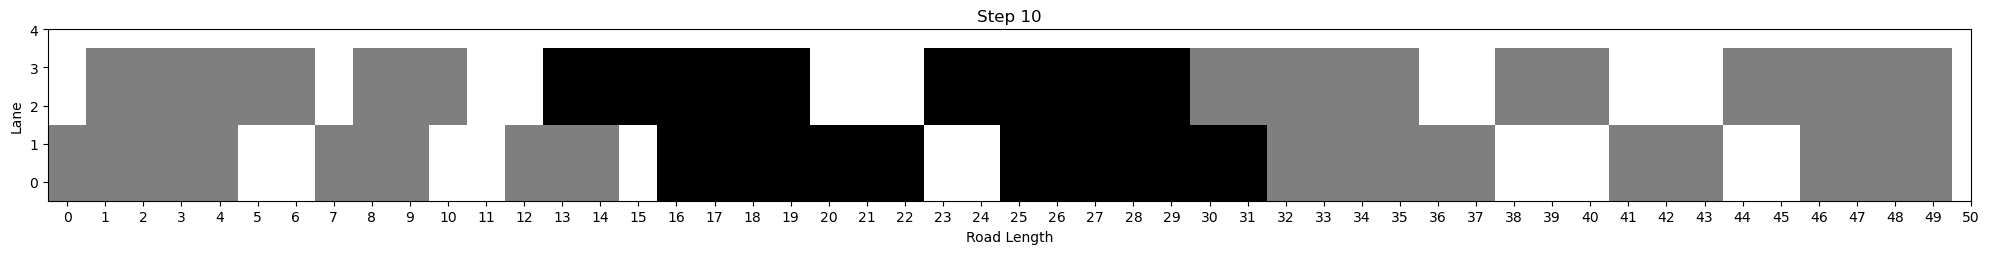

[[1. 1. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 2. 2.]
 [1. 1. 2. 2.]
 [0. 0. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 0. 0.]
 [2. 2. 0. 0.]
 [2. 2. 0. 0.]
 [0. 0. 2. 2.]
 [0. 0. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 1. 1.]
 [2. 2. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [0. 0. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [0. 0. 1. 1.]
 [0. 0. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
calling lane changing method
Vehicle 6 is located at row 0 with a speed of 2
jeep 6's rear bumper is at 35
jeep 6's front bumper is at 37
jeep 6's maximum distance is  2
jeep 6 has a gap distance of 2
jeep6 has a gap distance of 2 in its lane, vehic

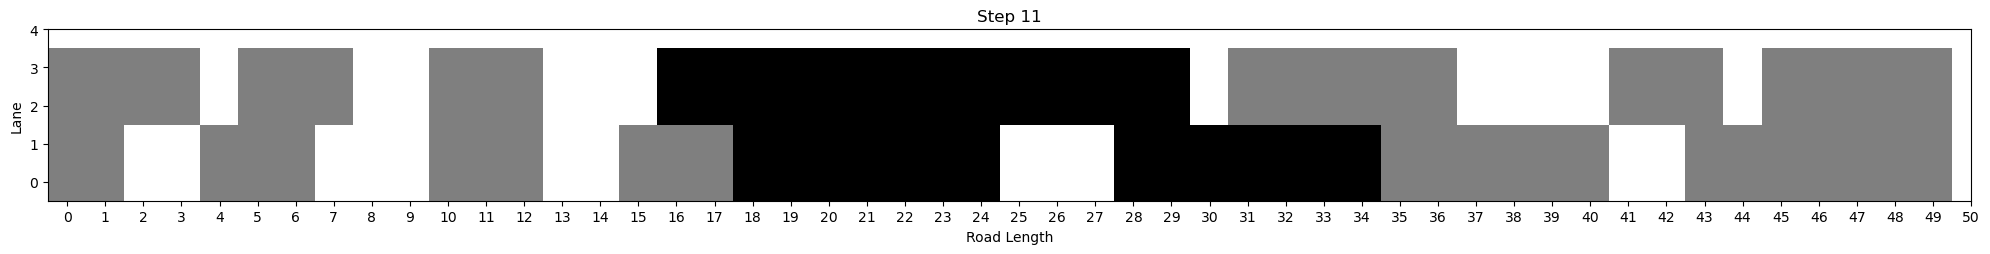

[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 2. 2.]
 [1. 1. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [0. 0. 2. 2.]
 [0. 0. 2. 2.]
 [0. 0. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 0. 0.]
 [2. 2. 1. 1.]
 [2. 2. 1. 1.]
 [2. 2. 1. 1.]
 [2. 2. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [0. 0. 1. 1.]
 [0. 0. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
calling lane changing method
Vehicle 19 is located at row 2 with a speed of 2
jeep 19's rear bumper is at 10
jeep 19's front bumper is at 12
jeep 19's maximum distance is  2
jeep 19 has a gap distance of 2
jeep19 has a gap distance of 2 in its lane,

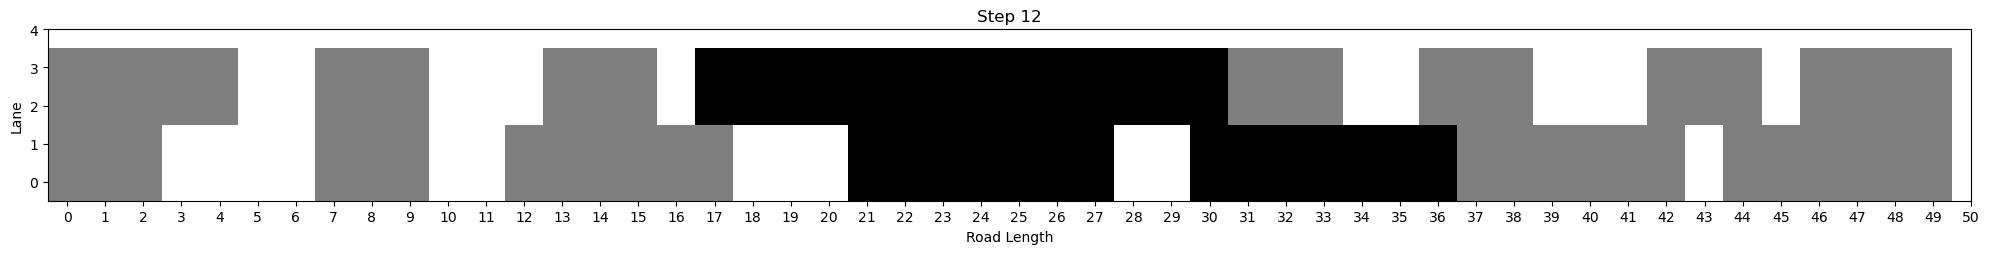

[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 2. 2.]
 [0. 0. 2. 2.]
 [0. 0. 2. 2.]
 [0. 0. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [0. 0. 2. 2.]
 [0. 0. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 1. 1.]
 [2. 2. 1. 1.]
 [2. 2. 1. 1.]
 [2. 2. 0. 0.]
 [2. 2. 0. 0.]
 [2. 2. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 1. 1.]
 [0. 0. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
calling lane changing method
Vehicle 0 is located at row 0 with a speed of 3
truck 0's rear bumper is at 21
truck 0's front bumper is at 27
truck 0's maximum distance is  3
4.0
truck 0 has a gap distance of 2
truck0 has a gap distance of 2 in its la

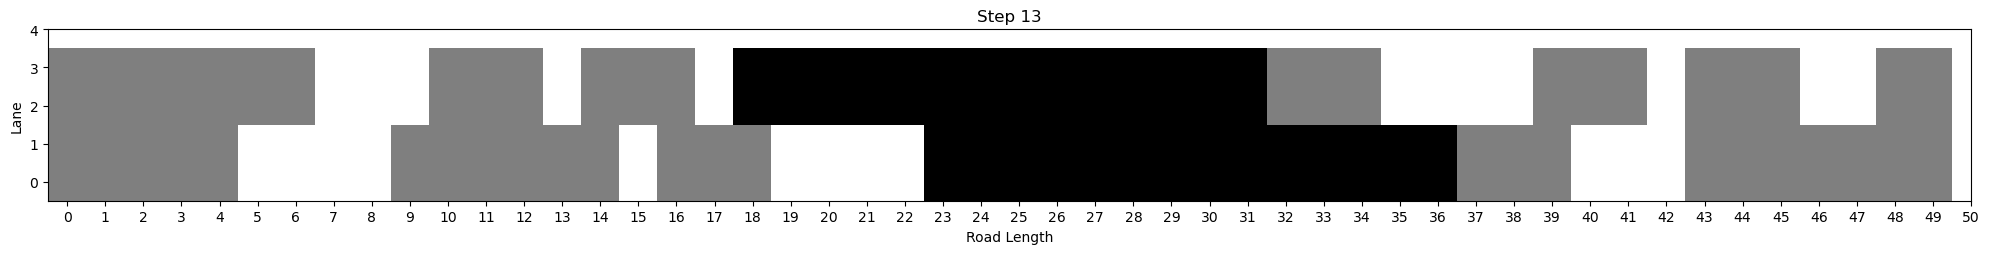

[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 1. 1.]
 [0. 0. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 2. 2.]
 [0. 0. 2. 2.]
 [0. 0. 2. 2.]
 [0. 0. 2. 2.]
 [0. 0. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 1. 1.]
 [2. 2. 1. 1.]
 [2. 2. 1. 1.]
 [2. 2. 0. 0.]
 [2. 2. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
calling lane changing method
Vehicle 15 is located at row 2 with a speed of 2
jeep 15's rear bumper is at 4
jeep 15's front bumper is at 6
jeep 15's maximum distance is  2
jeep 15 has a gap distance of 2
jeep15 has a gap distance of 2 in its lane, v

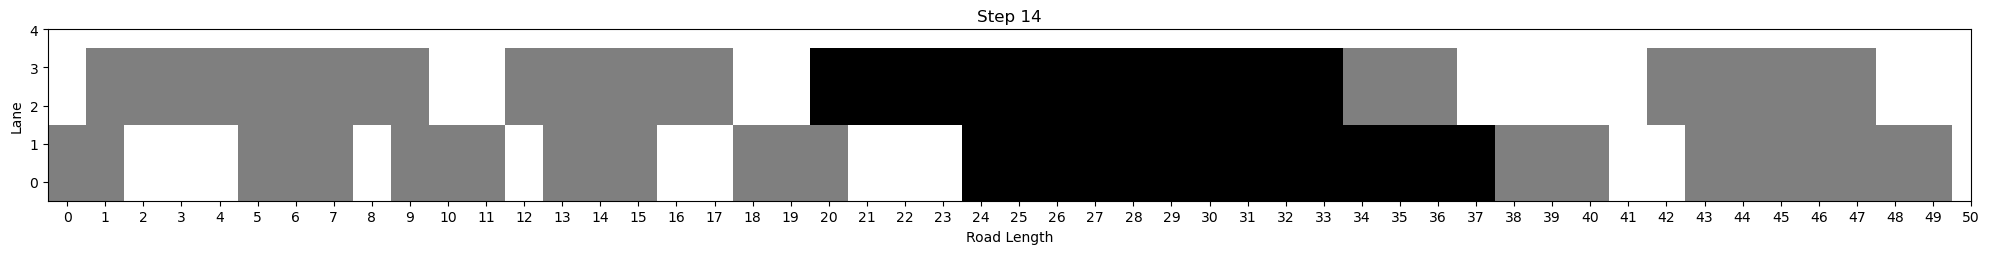

[[1. 1. 0. 0.]
 [1. 1. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [0. 0. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 2. 2.]
 [0. 0. 2. 2.]
 [0. 0. 2. 2.]
 [0. 0. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 1. 1.]
 [2. 2. 1. 1.]
 [2. 2. 1. 1.]
 [2. 2. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]]
calling lane changing method
Vehicle 11 is located at row 2 with a speed of 3
jeep 11's rear bumper is at 1
jeep 11's front bumper is at 3
jeep 11's maximum distance is  3
2.0
jeep 11 has a gap distance of 0
jeep11 has a gap distance of 0 in its lan

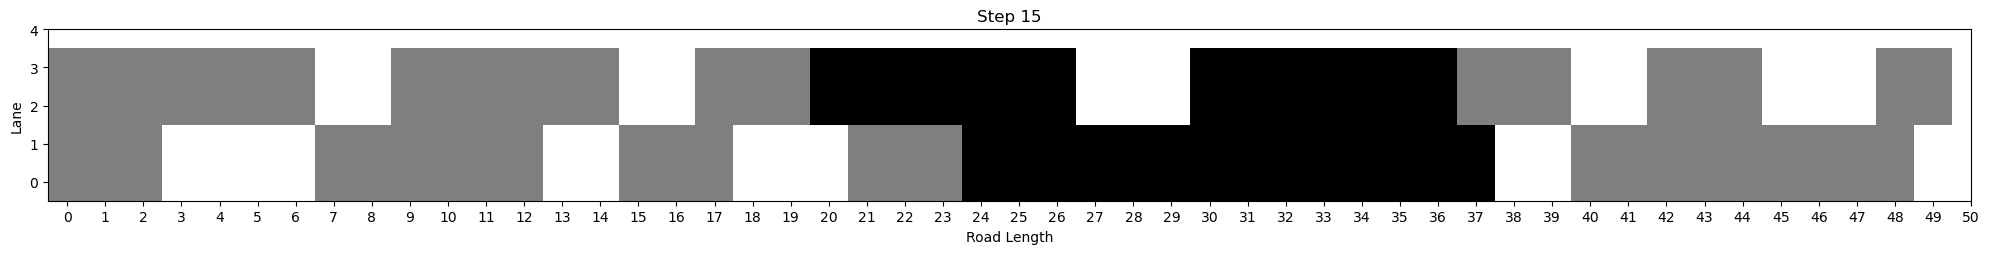

[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 2. 2.]
 [1. 1. 2. 2.]
 [1. 1. 2. 2.]
 [1. 1. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 0. 0.]
 [2. 2. 0. 0.]
 [2. 2. 0. 0.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 1. 1.]
 [0. 0. 1. 1.]]
calling lane changing method
Vehicle 18 is located at row 0 with a speed of 3
jeep 18's rear bumper is at 21
jeep 18's front bumper is at 23
jeep 18's maximum distance is  3
4.0
jeep 18 has a gap distance of 0
jeep18 has a gap distance of 0 in its l

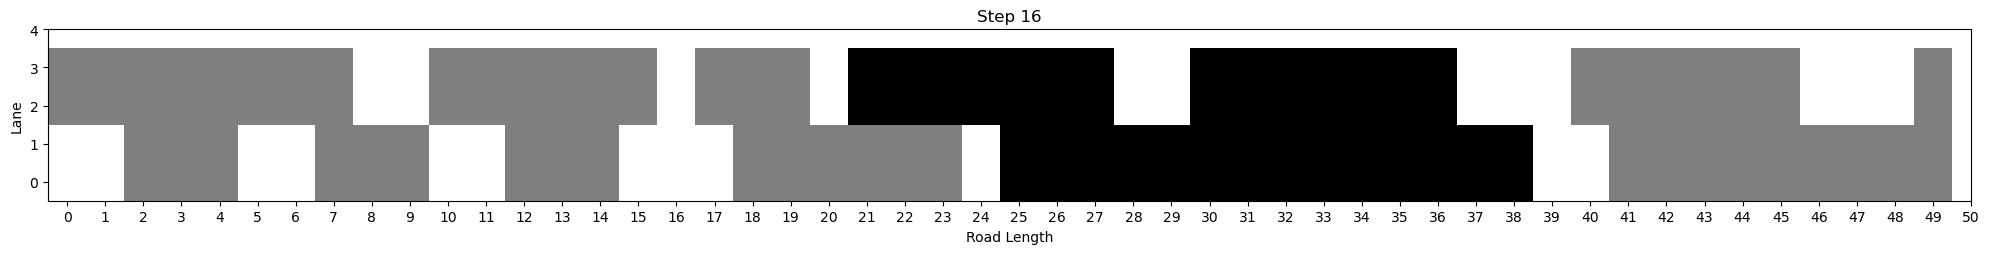

[[0. 0. 1. 1.]
 [0. 0. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [0. 0. 1. 1.]
 [0. 0. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 0. 0.]
 [0. 0. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 2. 2.]
 [1. 1. 2. 2.]
 [1. 1. 2. 2.]
 [0. 0. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 0. 0.]
 [2. 2. 0. 0.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 0. 0.]
 [2. 2. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 1. 1.]]
calling lane changing method
Vehicle 5 is located at row 2 with a speed of 3
jeep 5's rear bumper is at 40
jeep 5's front bumper is at 42
jeep 5's maximum distance is  3
2.0
jeep 5 has a gap distance of 0
jeep5 has a gap distance of 0 in its lane, v

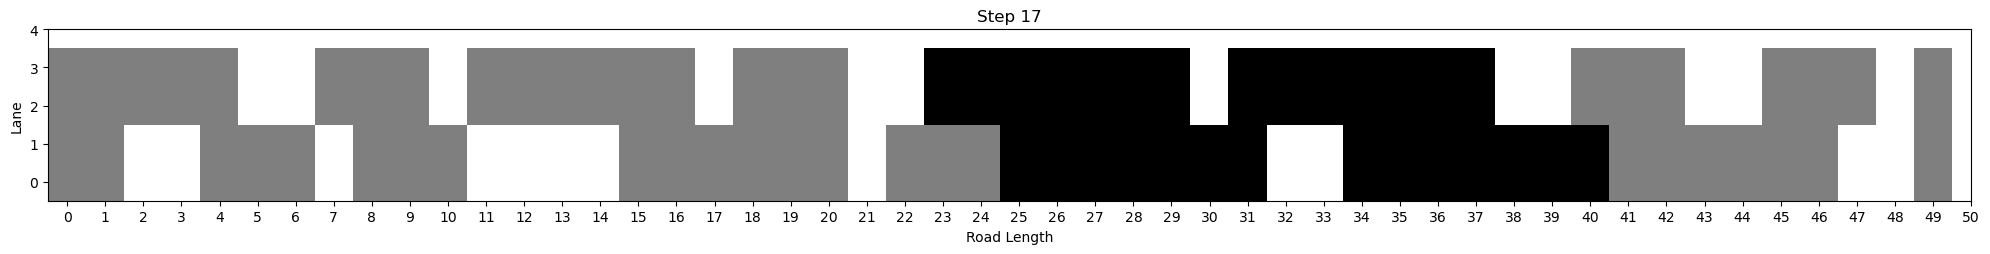

[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [0. 0. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 0. 0.]
 [0. 0. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 2. 2.]
 [1. 1. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 0. 0.]
 [2. 2. 2. 2.]
 [0. 0. 2. 2.]
 [0. 0. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 0. 0.]
 [2. 2. 0. 0.]
 [2. 2. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 0. 0.]
 [1. 1. 1. 1.]]
calling lane changing method
Vehicle 17 is located at row 2 with a speed of 1
jeep 17's rear bumper is at 14
jeep 17's front bumper is at 16
jeep 17's maximum distance is  1
jeep 17 has a gap distance of 1
jeep17 has a gap distance of 1 in its lane,

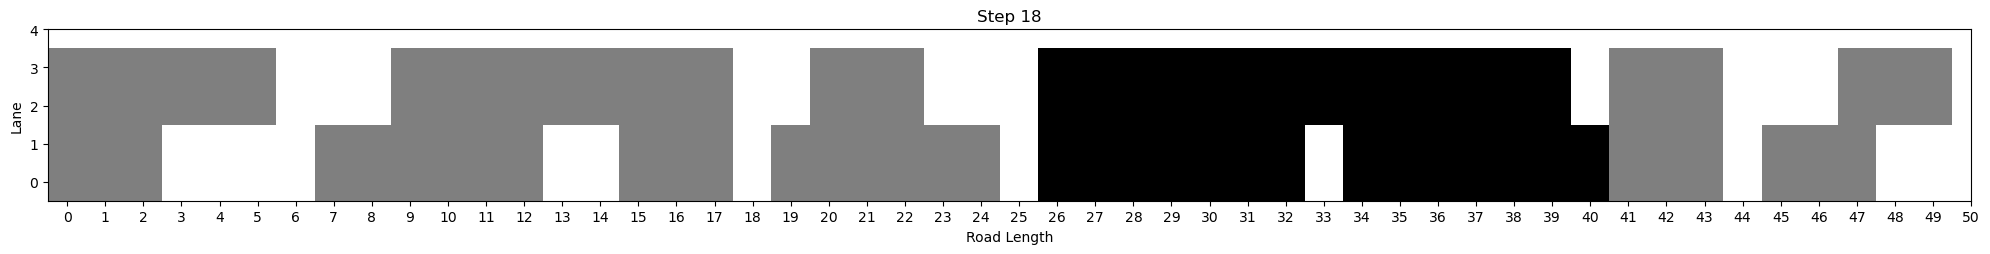

[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [0. 0. 0. 0.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [0. 0. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 1. 1.]]
calling lane changing method
Vehicle 19 is located at row 2 with a speed of 2
jeep 19's rear bumper is at 20
jeep 19's front bumper is at 22
jeep 19's maximum distance is  2
jeep 19 has a gap distance of 2
jeep19 has a gap distance of 2 in its lane,

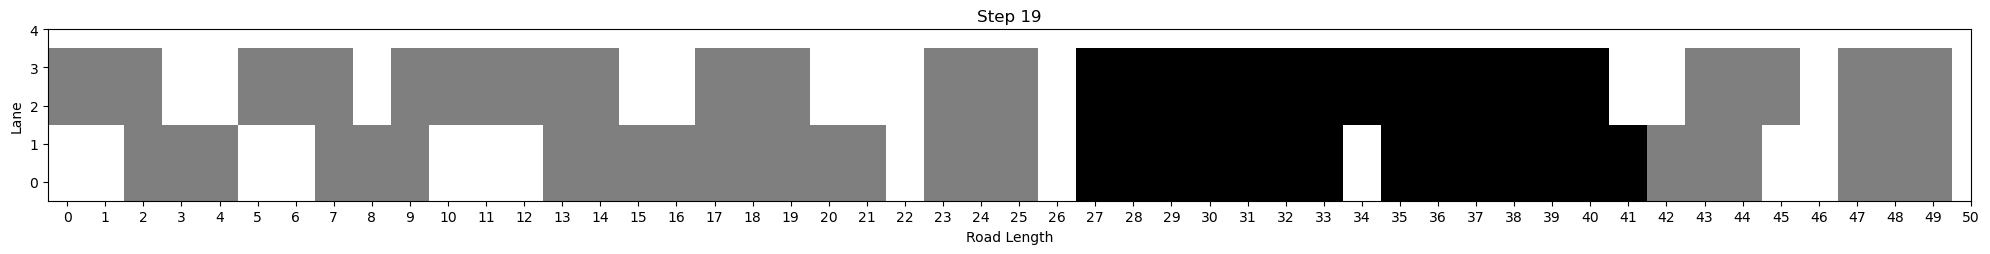

[[0. 0. 1. 1.]
 [0. 0. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [0. 0. 1. 1.]
 [0. 0. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]
 [0. 0. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 0. 0.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [0. 0. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 2. 2.]
 [2. 2. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 0. 0.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]


In [181]:
road = Road(road_length=50, road_width=4, speed_limit=5)
simulator = IntraRoadSimulator(road)

density = 0.7 # Example density
truck_fraction = 0.2 # Example truck fraction 
simulator.initialize_vehicles(density, truck_fraction, 1, 1)
simulator.visualize(0)
for step in range(20):
    simulator.simulation_step()
    if step % 1 == 0:
        simulator.visualize(step)
        print(simulator.road.road_occupancy)

In [ ]:
def animate(step):
    simulator.simulation_step()  # Run a simulation step
    ax.clear()  # Clear the previous plot
    ax.imshow(simulator.road.road_occupancy.T, cmap='gray_r', origin='lower')
    #ax.set_title(f'Time step {step}')
    #ax.set_xlabel('Road Length')
    #ax.set_ylabel('Row')
    #ax.set_xticks(range(0, simulator.road.road_length + 1, 1))
    #ax.set_yticks(range(0, simulator.road.road_width + 1, 1))
    #ax.grid(True)

# Initialize road and simulator
road = Road(road_length=100, road_width=4, speed_limit=5)
simulator = IntraRoadSimulator(road)

density = 1
truck_fraction = 0.7

simulator.initialize_vehicles(density, truck_fraction, 0, 0)  # Initialize vehicles

# Set up the figure and axis for animation
fig, ax = plt.subplots(figsize=(30, 12))

# Create the animation
anim = FuncAnimation(fig, animate, frames=1000, interval=300)

# Save the animation as a GIF or MP4
anim.save('road_simulation_jeeptruck_November13,15:30(density=1, truck fraction = 0.7, exclusive).gif', writer='pillow')
# Or save as MP4
# anim.save('road_simulation.mp4', writer='ffmpeg')

# Show the animation in a Jupyter notebook (if using one)
plt.show()